# Phase computation for pulsar using PINT

This notebook has been done for the following version of Gammapy and PINT:

Gammapy version : 1.0

PINT version : 0.9.3

This notebook shows how to compute and add the phase information into the events files of pulsar observations. This step is needed to perform the pulsar analysis with Gammapy and should be the first step in the high level analysis. For the pulsar analysis we need two ingredients:

1. The time of arrivals (TOAs). These times should have very high precision due to the common fast periods of pulsars. Usually these times are already stored in the EventList. For the computation of pulsar timing, times must be corrected in order to be referenced in the Solar System barycenter (SSB) because this system can nearly be regarded as an inertial reference frame with respect to the pulsar.


2. The model of rotation of the pulsar, also known as ephemeris, at the epoch of the observations. These ephemerides are stored in an specific format and saved as .par files and contain informations on the periods, derivatives of the periods, coordinates, glitches, etc.

__For the following steps of this tutorial, we need the original EventLists from the DL3 files, and a model in .par format.__

The main software that we will use to make the barycentric corrections and the phase-folding to the model is the PINT python library, [Luo J., Ransom S. et al., 2021](https://arxiv.org/abs/2012.00074), [ASCL](http://ascl.net/1902.007).
For more information about this package, see [PINT documentation](https://nanograv-pint.readthedocs.io/en/latest/). 

## 0. Dependencies and imports

In order to run this notebook, one need to have install Gammapy as well as PINT (see documentation above) in the same environment. We recommend to first install Gammapy and then install PINT using your prefered package manager.


`$ conda env create -n gammapy-pint -f gammapy-1.0-environment.yml`

`$ conda activate gammapy-pint`

`$ pip install pint-pulsar`

Alternatively, one can also run the yaml environement file provided in the folder of this notebook:

`$ conda env create -n gammapy-pint -f gammapy-pint-environment.yml`


In [3]:
import gammapy
import pint

print(f"Gammapy version : {gammapy.__version__}")
print(f"PINT version : {pint.__version__}")

Gammapy version : 1.0
PINT version : 0.9.3


In [4]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
import numpy as np
from pathlib import Path
from gammapy.data import DataStore, EventList, Observation

And we also need some imports from PINT:

In [5]:
import pint.models as pmodels
from pint import toa

## 1. Reading DataStore

First we neeed to define the data sample. In this notebook we will use two runs from the MAGIC gammapy data sample available in https://github.com/gammapy/gammapy-data

In [6]:
# Define the directory containing the DL3 data
DL3_direc = "$GAMMAPY_DATA/magic/rad_max/data"

In [7]:
# Read DataStore from a directory
data_store = DataStore.from_dir(DL3_direc)

Let's run this tutorial for the Crab pulsar :

In [8]:
target_pos = SkyCoord(ra = 083.6331144560900, dec = +22.0144871383400, unit = 'deg', frame = 'icrs')

In [9]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=target_pos.ra,
    lat=target_pos.dec,
    radius="5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

In [10]:
obs_id = selected_obs_table['OBS_ID']
print(obs_id)

 OBS_ID
-------
5029748
5029747


For the following we will take the run 5029747.

In [11]:
observations = data_store.get_observations([5029747], required_irf = "point-like")

In [12]:
print(observations)

Observations
Number of observations: 1
Observation

	obs id            : 5029747 
 	tstart            : 56569.18
	tstop             : 56569.19
	duration          : 1188.11 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 0.8%



## 2. Phase-folding with PINT for one observation

Let's extract the times from the observation:

In [13]:
# Extract times from EventList
observation = observations[0]
times = observation.events.time

In [14]:
print(times)

[56569.18112859 56569.18112878 56569.18112978 ... 56569.19487702
 56569.19487703 56569.19487876]


Now we have the TOAs of the events in the system of the telescope. Please note that the actual precision of the times is higher than the diplayed output (and we really need this precision for the pulsar analysis!). In the next step, the timing in the SSB and the phase for each TOA has to be created. 

## 2.1 An ephemeris file from Fermi-LAT data.

In order to compute the phases of a pulsar, one needs an ephemeris file, usually store as a .par file. 

In the following, we will use an ephemeris file for the Crab provided by Fermi-LAT, see [Kerr, M.; Ray, P. S.; et al; 2015](https://arxiv.org/abs/1510.05099). This ephemeris file for the Crab pulsar can be found alongside other pulsar ephemeris files at this [confluence page]( https://confluence.slac.stanford.edu/display/GLAMCOG/LAT+Gamma-ray+Pulsar+Timing+Models). 

However, be aware that most of these ephemeris files are not up-to-date. Therefore they could give bad results on the phase computation. In particular, one should always checked that the MJD of the observations one wants to phased lies between the `START`and `FINISH`entry of the ephemeris file.

In [15]:
# Path to the ephemeris file
ephemeris_file = './0534+2200_ApJ_708_1254_2010.par'

Note that sometimes one needs to change some of the parameters of the ephemeris file that are not used in gamma-ray astronomy by hand. For instance, here we have removed the 'JUMP' line since it does not have any effect in our computation and raise an error in PINT. The ephemeris file provided with this notebook does not have this line. 

## 2.2 Computing pulsar phases

Now that we have the model and the times of arrival for the different events, we can compute the timing corrections and the pulsar phases needed for the pulsar analysis. In this case, we use the PINT package described in the introduction.

First we will explore our model that should look at follows:

In [16]:
model = pmodels.get_model(ephemeris_file)
print(model)

2023-03-06 09:44:51.648 | INFO     | pint.models.absolute_phase:validate:72 - TZRFRQ was 0.0 or None. Setting to infinite frequency.


# Created: 2023-03-06T09:44:51.650445
# PINT_version: 0.9.3
# User: mregeard
# Host: Maximes-MacBook.local
# OS: macOS-13.1-x86_64-i386-64bit
# Format: pint
PSRJ                           J0534+2200
TRACK                                  -2
EPHEM                               DE405
CLK                               TT(TAI)
START              54686.1526259000000000
FINISH             56583.1591704000000000
DILATEFREQ                              N
DMDATA                                  N
NTOA                                  272
CHI2                                  0.0
RAJ                      5:34:31.94000000
DECJ                    22:00:52.10000000
PMRA                                -11.8 0 1.0
PMDEC                                 4.4 0 1.0
PX                                    0.0
POSEPOCH           50739.0000000000000000
F0                  29.716913767510206412 0 7.4407601857728877803e-08
F1              -3.7105744257791078768e-10 0 7.1826463672770942706e-16
F2              1.

/Users/mregeard/anaconda3/envs/gammapy-1.0-pint/lib/python3.9/site-packages/pint/models/model_builder.py:110: UserWarning: Unrecognized parfile line 'EPHVER 5'
  warnings.warn(f"Unrecognized parfile line '{p_line}'", UserWarning)


There are multiple parameters such as the name of the source, the interval of validity of the model (START to FINISH), the frequencies of rotation and its derivatives (F0,F1,F2). There are other additional parameters that can be checked in the [PINT documentation](https://nanograv-pint.readthedocs.io)

Now we can compute the phases. For that, we define a list of TOA objects that are the main object of PINT.

In [17]:
%%time

# Put these to True is your observatory has clock correction files. 
# If it is set to True but your observatory does not have clock correction files, it will be ignored.
include_bipm = False
include_gps = False

# Set this to True or False depending on your ephemeris file.
# Here we can see that the 'PLANET_SHAPIRO' entry is 'N' so we set it to True.
planets = False

# Create a TOA object for each time
toa_list = list(toa.TOA(MJD=t, error=1 * u.microsecond, obs='magic') for t in times)

# Create a TOAs object from a list of TOA
ts = toa.get_TOAs_list(toa_list,
                       ephem='DE421', 
                       include_gps=include_gps,  
                       include_bipm=include_bipm, 
                       planets=planets) 

2023-03-06 09:44:52.362 | DEBUG    | pint.toa:__init__:1327 - No pulse number flags found in the TOAs
2023-03-06 09:44:52.372 | DEBUG    | pint.toa:apply_clock_corrections:2132 - Applying clock corrections (include_gps = False, include_bipm = False)
2023-03-06 09:44:52.809 | INFO     | pint.observatory.topo_obs:clock_corrections:353 - Observatory magic requires no clock corrections.
2023-03-06 09:44:55.126 | DEBUG    | pint.toa:compute_TDBs:2182 - Computing TDB columns.
2023-03-06 09:44:55.127 | DEBUG    | pint.toa:compute_TDBs:2207 - Using EPHEM = DE421 for TDB calculation.
2023-03-06 09:44:55.972 | DEBUG    | pint.toa:compute_posvels:2298 - Computing PosVels of observatories and Earth, using DE421
2023-03-06 09:44:57.048 | INFO     | pint.solar_system_ephemerides:_load_kernel_link:53 - Set solar system ephemeris to de421 from download
2023-03-06 09:44:58.067 | DEBUG    | pint.toa:compute_posvels:2353 - SSB obs pos [1.47007462e+11 2.56889811e+10 1.11245045e+10] m
2023-03-06 09:44:58.8

CPU times: user 5.44 s, sys: 110 ms, total: 5.55 s
Wall time: 7.26 s


Once we have the TOAs object and the model, the phases are easily computed using the model.phase() method. Note that the phases are computed in the interval [-0.5,0.5]. Most of the times, we use the phases in the interval [0,1] so we have to shift the negative ones.

In [18]:
# Compute phases
phases = model.phase(ts,abs_phase=True)[1]
                
# Shift phases to the interval (0,1]
phases = np.where(phases < 0.0 , phases + 1.0 , phases)

2023-03-06 09:44:59.053 | DEBUG    | pint.models.glitch:glitch_phase:212 - Glitch phase for glitch 1: 0.0 
2023-03-06 09:44:59.068 | DEBUG    | pint.models.absolute_phase:get_TZR_toa:97 - Creating and dealing with the single TZR_toa for absolute phase
2023-03-06 09:44:59.069 | DEBUG    | pint.toa:__init__:1327 - No pulse number flags found in the TOAs
2023-03-06 09:44:59.069 | DEBUG    | pint.toa:apply_clock_corrections:2132 - Applying clock corrections (include_gps = False, include_bipm = False)
2023-03-06 09:44:59.070 | DEBUG    | pint.toa:compute_TDBs:2182 - Computing TDB columns.
2023-03-06 09:44:59.070 | DEBUG    | pint.toa:compute_TDBs:2207 - Using EPHEM = DE421 for TDB calculation.
2023-03-06 09:44:59.072 | DEBUG    | pint.toa:compute_posvels:2298 - Computing PosVels of observatories and Earth, using DE421
2023-03-06 09:44:59.800 | INFO     | pint.solar_system_ephemerides:_load_kernel_link:53 - Set solar system ephemeris to de421 from download
2023-03-06 09:44:59.814 | DEBUG    

## 3. Adding phases and metadata to an EventList and put it in a new Observation. 

Once the phases are computed we need to create a new EventList table that includes both the original information of the events and the phase information in extra columns. This is necessary for Gammapy to read the phases and use them as an extra variable of each event.

In [19]:
# Extract the table of the EventList
table = observation.events.table

In [20]:
# Show original table
table

EVENT_ID,TIME,RA,DEC,ENERGY
,s,deg,deg,TeV
int64,float64,float32,float32,float32
2402,333778852.5099249,84.59457,22.03088,0.18194601
2408,333778852.5267153,84.21462,23.44914,0.08397394
2434,333778852.61315054,83.524704,22.725792,0.10596932
2445,333778852.6690142,83.76957,22.451006,0.19733498
2478,333778852.7627939,83.478516,23.484594,0.08522219
2481,333778852.7778549,83.71517,21.985115,1.0020943
2513,333778852.8644467,82.421196,22.567652,0.14374068
2544,333778852.9826064,83.64136,22.041315,0.10316629


In [21]:
# Add a column for the phases to the table
table['PHASE'] = phases.astype('float64')

Note that you can add multiple columns to a same file, only the name of the column has to be unique, eg `table['PHASE_SRC1']`, `table['PHASE_SRC2']` etc"

In [22]:
# Show table with phases
table

EVENT_ID,TIME,RA,DEC,ENERGY,PHASE
,s,deg,deg,TeV,
int64,float64,float32,float32,float32,float64
2402,333778852.5099249,84.59457,22.03088,0.18194601,0.39349195931383935
2408,333778852.5267153,84.21462,23.44914,0.08397394,0.8919526792392973
2434,333778852.61315054,83.524704,22.725792,0.10596932,0.4579789031294724
2445,333778852.6690142,83.76957,22.451006,0.19733498,0.11641860219368931
2478,333778852.7627939,83.478516,23.484594,0.08522219,0.9004806857711186
2481,333778852.7778549,83.71517,21.985115,1.0020943,0.34760116922550754
2513,333778852.8644467,82.421196,22.567652,0.14374068,0.9182741001617851
2544,333778852.9826064,83.64136,22.041315,0.10316629,0.4261124944482102


Now we can see that the 'PHASE' column has been added to the table

At this point, we also want to add meta data to the table. It is very useful to keep track of what has been done to the file. For instance, if we have multiple pulsars in the same file, we want to be able to know quickly which column correspond to which pulsar. Moreover, experience shows that one often use different ephemeris file for the same pulsar. Therefore it is very useful to have several phase columns in the same file and to be able to know which column correspond to which ephemeris file, parameters, etc.

Since there is not yet a "standard" format for such metadata, we propose a template for the essential informations that one wants to save in the header of the event file. 

In [23]:
table.meta

OrderedDict([('EXTNAME', 'EVENTS'),
             ('HDUCLASS', 'GADF'),
             ('HDUDOC',
              'https://github.com/open-gamma-ray-astro/gamma-astro-data-formats'),
             ('HDUVERS', '0.2'),
             ('HDUCLAS1', 'EVENTS'),
             ('OBS_ID', 5029747),
             ('TSTART', 333778852.435217),
             ('TSTOP', 333780040.546979),
             ('ONTIME', 1188.111761868),
             ('LIVETIME', 1178.06621791733),
             ('DEADC', 0.991545),
             ('EQUINOX', 2000.0),
             ('RADECSYS', 'FK5'),
             ('ORIGIN', 'MAGIC Collaboration'),
             ('TELESCOP', 'MAGIC'),
             ('INSTRUME', 'MAGIC stereo'),
             ('CREATOR', 'MAGIC_DL3'),
             ('VERSION', '0.1.8'),
             ('MJDREFI', 52706),
             ('MJDREFF', 0.0),
             ('TIMEUNIT', 's'),
             ('TIMESYS', 'UTC'),
             ('TIMEREF', 'local'),
             ('OBJECT', 'CrabNebula'),
             ('RA_OBJ', 83.63333),
      

In [24]:
def get_log(ephemeris_file , phase_column_name = 'PHASE'):
    return ('COLUMN_PHASE: ' + str(phase_column_name) 
+ '; PINT_VERS: ' + pint.__version__ 
+ '; GAMMAPY_VERS: ' + gammapy.__version__ 
+ '; EPHEM_FILE: ' + ephemeris_file 
+ '; PSRJ :' + str(model.PSR.value) 
+ '; START: ' + str(model.START.value) 
+ '; FINISH: ' + str(model.FINISH.value) 
+ '; TZRMJD: ' + str(model.TZRMJD.value) 
+ '; TZRSITE: ' + str(model.TZRSITE.value) 
+ '; TZRFREQ: ' + str(model.TZRFRQ.value) 
+ '; EPHEM: ' + str(model.EPHEM.value) 
+ '; EPHEM_RA: ' + str(model.RAJ.value) 
+ '; EPHEM_DEC: ' + str(model.DECJ.value)
+ '; PHASE_OFFSET: ' + 'default = 0'
+ '; DATE: ' + str(Time.now().mjd) + ';')

In [25]:
phase_log = get_log(ephemeris_file=ephemeris_file, phase_column_name = 'PHASE')
print(phase_log)

COLUMN_PHASE: PHASE; PINT_VERS: 0.9.3; GAMMAPY_VERS: 1.0; EPHEM_FILE: ./0534+2200_ApJ_708_1254_2010.par; PSRJ :J0534+2200; START: 54686.1526259; FINISH: 56583.1591704; TZRMJD: 55638.155277599951656; TZRSITE: coe; TZRFREQ: inf; EPHEM: DE405; EPHEM_RA: 5.575538888888889; EPHEM_DEC: 22.01447222222222; PHASE_OFFSET: default = 0; DATE: 60009.36459243983;


In [26]:
# Add the generated string to the meta data of the table
table.meta['PH_LOG'] = phase_log

In [27]:
table.meta

OrderedDict([('EXTNAME', 'EVENTS'),
             ('HDUCLASS', 'GADF'),
             ('HDUDOC',
              'https://github.com/open-gamma-ray-astro/gamma-astro-data-formats'),
             ('HDUVERS', '0.2'),
             ('HDUCLAS1', 'EVENTS'),
             ('OBS_ID', 5029747),
             ('TSTART', 333778852.435217),
             ('TSTOP', 333780040.546979),
             ('ONTIME', 1188.111761868),
             ('LIVETIME', 1178.06621791733),
             ('DEADC', 0.991545),
             ('EQUINOX', 2000.0),
             ('RADECSYS', 'FK5'),
             ('ORIGIN', 'MAGIC Collaboration'),
             ('TELESCOP', 'MAGIC'),
             ('INSTRUME', 'MAGIC stereo'),
             ('CREATOR', 'MAGIC_DL3'),
             ('VERSION', '0.1.8'),
             ('MJDREFI', 52706),
             ('MJDREFF', 0.0),
             ('TIMEUNIT', 's'),
             ('TIMESYS', 'UTC'),
             ('TIMEREF', 'local'),
             ('OBJECT', 'CrabNebula'),
             ('RA_OBJ', 83.63333),
      

Once this is done, we can put back the table in a new `EventList` object and in a new `Observation` object. 

In [29]:
# Create new event list and add it to observation object
new_event_list = EventList(table)
new_obs = observation.copy(in_memory=True, events=new_event_list)

## 4. Save new Event List and writing a modify HDU index table

In the following, we show how to write the files in a directory contained in the original datastore directory. This follows the logic of DL3 data store and facilitate the manipulation of the HDU table.

If one does not want to save the events files and directly perform the pulsar analysis, this step is not required as well as the step of the meta data handling. However, be aware that for large dataset, the computation of phases can take tens of minutes. 

In [30]:
data_store.hdu_table.base_dir

PosixPath('/Users/mregeard/Workspace/data/gammapy-data/gammapy-datasets/dev/magic/rad_max/data')

In [31]:
# Define output directory and filename
datastore_dir = str(data_store.hdu_table.base_dir) + '/'
output_directory = 'pulsar_events_file/'
output_path = datastore_dir + output_directory
filename = f'dl3_pulsar_{observation.obs_id:04d}.fits.gz'
file_path = output_path + filename

Path(output_path).mkdir(parents=True, exist_ok=True)

In [32]:
output_path

'/Users/mregeard/Workspace/data/gammapy-data/gammapy-datasets/dev/magic/rad_max/data/pulsar_events_file/'

In [33]:
# Save the observation object in the specified file_path
print('Writing outputfile in '+str(file_path))
observation.events.write(filename = file_path, gti = observation.gti, overwrite=True)

Writing outputfile in /Users/mregeard/Workspace/data/gammapy-data/gammapy-datasets/dev/magic/rad_max/data/pulsar_events_file/dl3_pulsar_5029747.fits.gz


Once the file has been written, we want to write a modified version of the HDU table. This is mandatory if we want to open the phased events file together with its associated IRFs. 

In [34]:
# Print the current data store HDU table. 
new_hdu = data_store.hdu_table.copy()
new_hdu

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME
int64,bytes30,bytes30,bytes100,bytes50,bytes30
5029748,events,events,./,20131004_05029748_DL3_CrabNebula-W0.40+215.fits,EVENTS
5029748,gti,gti,./,20131004_05029748_DL3_CrabNebula-W0.40+215.fits,GTI
5029748,rad_max,rad_max_2d,./,20131004_05029748_DL3_CrabNebula-W0.40+215.fits,RAD_MAX
5029748,aeff,aeff_2d,./,20131004_05029748_DL3_CrabNebula-W0.40+215.fits,EFFECTIVE AREA
5029748,edisp,edisp_2d,./,20131004_05029748_DL3_CrabNebula-W0.40+215.fits,ENERGY DISPERSION
5029747,events,events,./,20131004_05029747_DL3_CrabNebula-W0.40+035.fits,EVENTS
5029747,gti,gti,./,20131004_05029747_DL3_CrabNebula-W0.40+035.fits,GTI
5029747,rad_max,rad_max_2d,./,20131004_05029747_DL3_CrabNebula-W0.40+035.fits,RAD_MAX
5029747,aeff,aeff_2d,./,20131004_05029747_DL3_CrabNebula-W0.40+035.fits,EFFECTIVE AREA


In [35]:
for entry in new_hdu: 
    if entry['HDU_NAME'] == 'EVENTS' and entry['OBS_ID'] == observation.obs_id:
        entry['FILE_DIR'] = './' + str(output_directory)
        entry['FILE_NAME'] = filename

In [36]:
new_hdu

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME
int64,bytes30,bytes30,bytes100,bytes50,bytes30
5029748,events,events,./,20131004_05029748_DL3_CrabNebula-W0.40+215.fits,EVENTS
5029748,gti,gti,./,20131004_05029748_DL3_CrabNebula-W0.40+215.fits,GTI
5029748,rad_max,rad_max_2d,./,20131004_05029748_DL3_CrabNebula-W0.40+215.fits,RAD_MAX
5029748,aeff,aeff_2d,./,20131004_05029748_DL3_CrabNebula-W0.40+215.fits,EFFECTIVE AREA
5029748,edisp,edisp_2d,./,20131004_05029748_DL3_CrabNebula-W0.40+215.fits,ENERGY DISPERSION
5029747,events,events,./pulsar_events_file/,dl3_pulsar_5029747.fits.gz,EVENTS
5029747,gti,gti,./,20131004_05029747_DL3_CrabNebula-W0.40+035.fits,GTI
5029747,rad_max,rad_max_2d,./,20131004_05029747_DL3_CrabNebula-W0.40+035.fits,RAD_MAX
5029747,aeff,aeff_2d,./,20131004_05029747_DL3_CrabNebula-W0.40+035.fits,EFFECTIVE AREA


We see that the `FILE_DIR`and `FILE_NAME`entry have been modified for our phased events file.

Finally, we need to save the new HDU table in the origianl DL3 directory. Here one should be very careful to not name the new HDU file with the same name as the original HDU file of the data store. Otherwise, the original HDU file will be overwrited. 

In [37]:
new_hdu.write(datastore_dir + 'hdu-index-pulsar.fits.gz', format='fits', overwrite=True)

**Note: Here we use only one approach that could be useful, showing the steps to save the new Event files in a random directory and generate a new modified HDU index table. However, the user is free to chose the absolute path of the EventList and DataStore.  For instance, another approach could be making a full copy of the DataStore, or changing the location of the pulsar event files to one that could be more convinient for the user.**

## 5. Opening the new DataStore

Once all of this is done, we just have to open the data store using `DataStore.from_dir()`and passing the pulsar HDU table to it :

In [38]:
pulsar_datastore = DataStore.from_dir(DL3_direc, hdu_table_filename='hdu-index-pulsar.fits.gz')

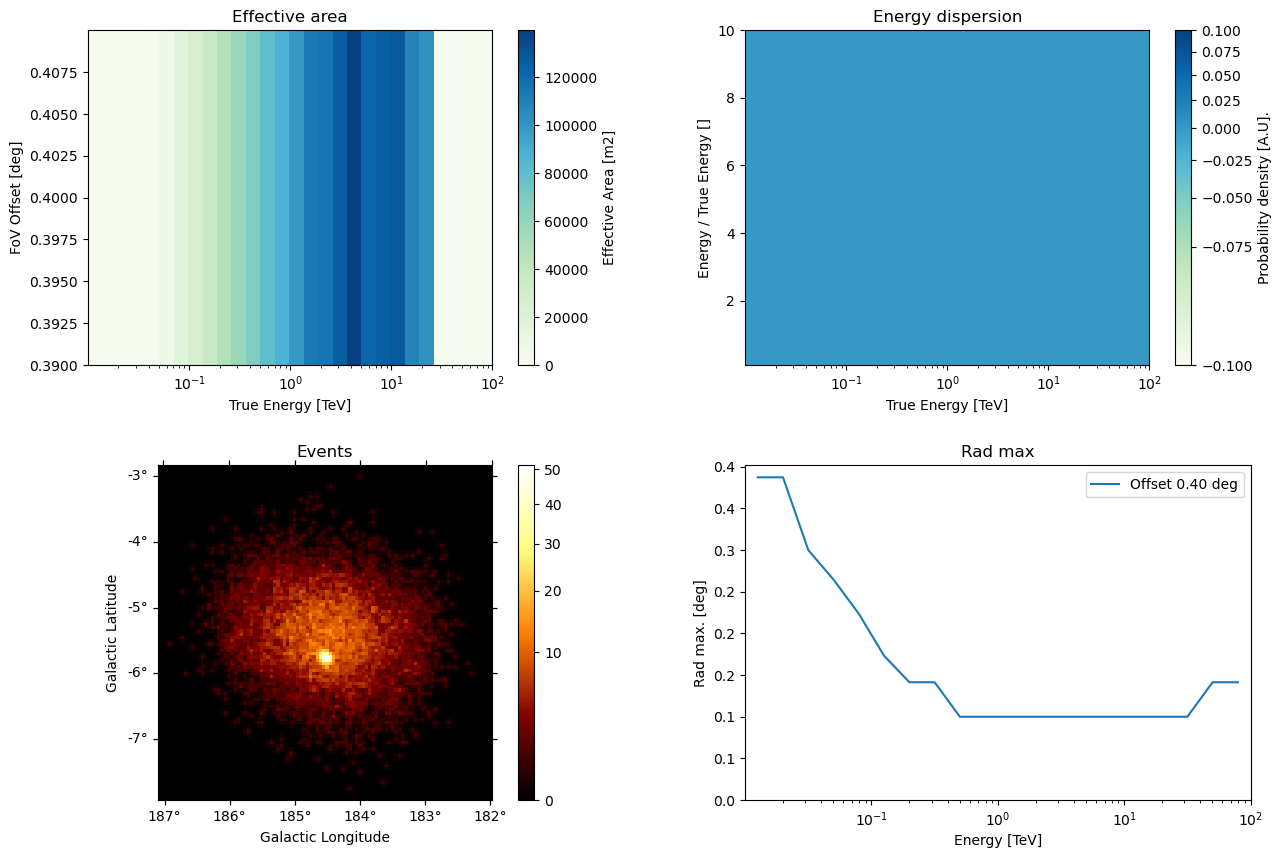

In [39]:
observations = pulsar_datastore.get_observations([5029747], required_irf = "point-like")
observations[0].peek()

In [40]:
observations[0].events.table

EVENT_ID,TIME,RA,DEC,ENERGY
,s,deg,deg,TeV
int64,float64,float32,float32,float32
2402,333778852.5099249,84.59457,22.03088,0.18194601
2408,333778852.5267153,84.21462,23.44914,0.08397394
2434,333778852.61315054,83.524704,22.725792,0.10596932
2445,333778852.6690142,83.76957,22.451006,0.19733498
2478,333778852.7627939,83.478516,23.484594,0.08522219
2481,333778852.7778549,83.71517,21.985115,1.0020943
2513,333778852.8644467,82.421196,22.567652,0.14374068
2544,333778852.9826064,83.64136,22.041315,0.10316629


We can see that we recover both the IRFs and the events file with the phase column.

## 6. Pulsar analysis tools with gammapy

Once we have the corret DataStore and the modified EventList with the phase information, we can do the pulsar analysis using different tools for Gammapy to compute the phaseogram, maps, SED, lightcurve, etc... To do so, one can check the following [Gammapy tutorial](https://docs.gammapy.org/1.0/tutorials/analysis-time/pulsar_analysis.html#sphx-glr-tutorials-analysis-time-pulsar-analysis-py).


Recipe made by [Alvaros Mas](https://github.com/alvmas), [Maxime Regeard](https://github.com/MRegeard), [Jan Lukas Schubert](https://github.com/jalu98).